# Regularisation in NNs

## 1. Set up the environment

In [1]:
# Import statements
from tensorflow import keras as kr 
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
# Set my plotting style
plt.style.use(('dark_background', 'bmh'))
plt.rc('axes', facecolor='none')
plt.rc('figure', figsize=(16, 4))

In [5]:
# Set random seed for reproducibility
np.random.seed(0)
torch.manual_seed(0)

In [6]:
# Shortcuts
imdb = kr.datasets.imdb
Tokeniser = kr.preprocessing.text.Tokenizer

## 2. Loading the data set

In [7]:
# Set the number of features we want
features_nb = 1000

# Load data and target vector from movie review data
(train_data, train_target), (test_data, test_target) = imdb.load_data(num_words=features_nb)

# Convert movie review data to a one-hot encoded feature matrix
tokeniser = Tokeniser(num_words=features_nb)
train_features = tokeniser.sequences_to_matrix(train_data, mode='binary')
test_features = tokeniser.sequences_to_matrix(test_data, mode='binary')

### 2.1 Exploring the data set

In [8]:
# Check data set sizes
print('train_data.shape:', train_data.shape)
print('train_target.shape:', train_target.shape)
print('test_data.shape:', test_data.shape)
print('test_target.shape:', test_target.shape)

train_data.shape: (25000,)
train_target.shape: (25000,)
test_data.shape: (25000,)
test_target.shape: (25000,)


In [9]:
# Check format of first training sample
print('type(train_data[0]):', type(train_data[0]))
print('type(train_target[0]):', type(train_target[0]))

type(train_data[0]): <class 'list'>
type(train_target[0]): <class 'numpy.int64'>


In [10]:
# Check size of first 10 training samples and corresponding target
print('Reviews length:', [len(sample) for sample in train_data[:10]])
print('Review sentiment (bad/good):', train_target[:10])

Reviews length: [218, 189, 141, 550, 147, 43, 123, 562, 233, 130]
Review sentiment (bad/good): [1 0 0 1 0 0 1 0 1 0]


In [11]:
# Show first review - machine format
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 2, 2, 65, 458, 2, 66, 2, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 2, 2, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2, 19, 14, 22, 4, 2, 2, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 2, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2, 2, 16, 480, 66, 2, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 2, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 2, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 2, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 2, 88, 12, 16, 283, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32]


In [12]:
# Data set text visualisation helper function
def show_text(sample):
    word_to_id = imdb.get_word_index()
    word_to_id = {k:(v+3) for k,v in word_to_id.items()}
    word_to_id["<PAD>"] = 0
    word_to_id["<START>"] = 1
    word_to_id["<UNK>"] = 2

    id_to_word = {value:key for key,value in word_to_id.items()}
    print(' '.join(id_to_word[id_] for id_ in sample))

In [13]:
# Show first review - human format
show_text(train_data[0])

<START> this film was just brilliant casting <UNK> <UNK> story direction <UNK> really <UNK> the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same <UNK> <UNK> as myself so i loved the fact there was a real <UNK> with this film the <UNK> <UNK> throughout the film were great it was just brilliant so much that i <UNK> the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the <UNK> <UNK> was amazing really <UNK> at the end it was so sad and you know what they say if you <UNK> at a film it must have been good and this definitely was also <UNK> to the two little <UNK> that played the <UNK> of <UNK> and paul they were just brilliant children are often left out of the <UNK> <UNK> i think because the stars that play them all <UNK> up are such a big <UNK> for the whole film but these children are amazing and should be <UNK> for what they have done don't yo

In [14]:
# Show first review - neural net format
print(train_features[0])

[0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0.
 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0.
 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0.
 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [15]:
# Show first review - neural net format - explanation
print(train_features[0] * np.arange(len(train_features[0])))

[  0.   1.   2.   0.   4.   5.   6.   7.   8.   9.   0.   0.  12.  13.
  14.  15.  16.  17.  18.  19.   0.  21.  22.   0.   0.  25.  26.   0.
  28.   0.  30.   0.  32.  33.   0.  35.  36.   0.  38.  39.   0.   0.
   0.  43.   0.   0.  46.   0.  48.   0.  50.  51.  52.   0.   0.   0.
  56.   0.   0.   0.   0.   0.  62.   0.   0.  65.  66.   0.   0.   0.
   0.  71.   0.   0.   0.   0.  76.  77.   0.   0.   0.   0.  82.   0.
   0.   0.   0.  87.  88.   0.   0.   0.  92.   0.   0.   0.   0.   0.
  98.   0. 100.   0.   0. 103. 104.   0. 106. 107.   0.   0.   0.   0.
 112. 113.   0.   0.   0. 117.   0.   0.   0.   0.   0.   0. 124.   0.
   0.   0.   0.   0. 130.   0.   0.   0. 134. 135.   0.   0.   0.   0.
   0. 141.   0.   0. 144.   0.   0. 147.   0.   0. 150.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 167.
   0.   0.   0.   0. 172. 173.   0.   0.   0.   0. 178.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 192.   0. 194.   0.
   0. 

## 3. Exploring regularisation of NN

Play with the code, especially the one marked `# toggle`.  
Start from `# toggle 0`, and then, one at the time, `# toggle 1` to `5`.

In [128]:
model = nn.Sequential(
    #nn.Dropout(0.2),  #toggle 3
    nn.Linear(features_nb, 16),
    nn.ReLU(),
    nn.Linear(16, 16),
    nn.ReLU(),
    #nn.Dropout(0.5),  #toggle3
    nn.Linear(16, 1),
    nn.Sigmoid()
)

In [112]:
epochs = 10
log_interval = 5000
batch_size = 100

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)  #toggle 1
#l2 regularization can be added in the same fashion as L1, but it can also be added via a weight_decay parameter 
#directly in the optimizer (for all the layers)
#l2_regularization_factor = 0.0005     #toggle 1
#optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, weight_decay = l2_regularization_factor) #toggle 1

#L1 regularization. Apply only to the first layer
#l1_regularization_factor = 0.0001   #toggle 2
#The model.params() would return a generator over all layers and activations. We would only need to retain 1st
#params = next(model.parameters())    #toggle 2

In [113]:
model

Sequential(
  (0): Dropout(p=0.2)
  (1): Linear(in_features=1000, out_features=16, bias=True)
  (2): ReLU()
  (3): Linear(in_features=16, out_features=16, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.5)
  (6): Linear(in_features=16, out_features=1, bias=True)
  (7): Sigmoid()
)

In [ ]:
def numpy_to_tensor(x, y):
    '''
    Convertx numpy array feature vector and a scalar target label to PyTorch tensors
    '''
    return torch.from_numpy(x).float(), torch.FloatTensor([y])

In [1]:
train_size = len(train_target)
test_size = len(test_target)

epoch = 0
#log training and test losses per epoch
train_loss = []
test_loss = []
train_acc = []
test_acc = []
import time

start = time.time()
while epoch < epochs:

    correct = 0
    for batch_idx in range(train_size):
        xs, y = numpy_to_tensor(train_features[batch_idx], train_target[batch_idx])
        
        y_pred = model(xs)
        loss = criterion(y_pred, y)
        #Enable L1 regularisation
        #loss += l1_regularization_factor * torch.abs(params).sum()   #toggle 2

        optimizer.zero_grad()
        loss.backward()
        #nn.utils.clip_grad_norm(model.parameters(), 1) #toggle  4
        optimizer.step()

        pred = 0 if y_pred.item() < 0.5 else 1
        correct += y.item() == pred

    train_loss.append(loss.item())
    train_acc.append(float(correct) / train_size)
    epoch += 1

    correct = 0
    with torch.no_grad():
        for batch_idx in range(test_size):
            xs, y = numpy_to_tensor(test_features[batch_idx], test_target[batch_idx])
            y_pred = model(xs)
            pred = 0 if y_pred.item() < 0.5 else 1
            correct += y.item() == pred
            loss = criterion(y_pred, y)

    test_acc.append(float(correct) / test_size)
    test_loss.append(loss.item())
    print('After epoch {}, traing accuracy: {} test accuracy: {}'.format(epoch, train_acc[-1], test_acc[-1]))
    
print("Elapsed time {}".format(time.time()-start))    

NameError: name 'train_target' is not defined

In [131]:
# Create count of the number of epochs
epoch = range(1, len(test_loss) + 1)

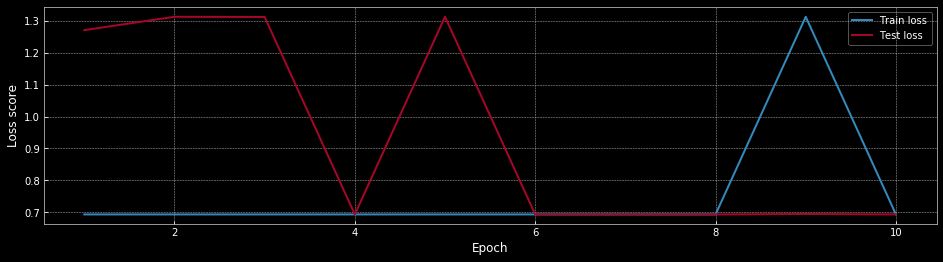

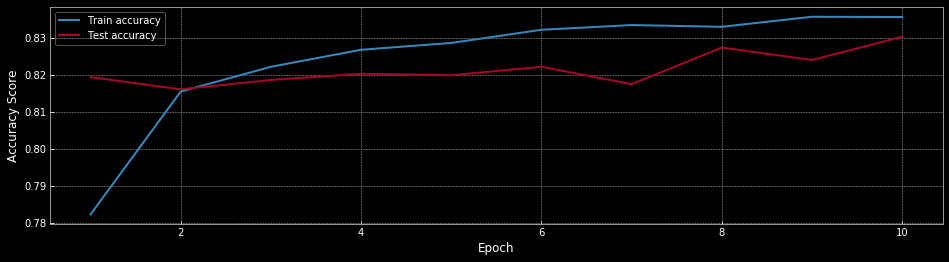

In [130]:
# Visualize loss history
plt.figure()

plt.plot(epoch, train_loss)
plt.plot(epoch, test_loss)
#plt.plot(no_reg['epoch'], no_reg['train_loss'])  # toggle 1
#plt.plot(no_reg['epoch'], no_reg['test_loss'])  # toggle 1

plt.legend(['Train loss', 'Test loss', 'Train no-reg', 'Test no-reg'])
plt.xlabel('Epoch')
plt.ylabel('Loss score')


# Visualize accuracy history
plt.figure()

plt.plot(epoch, train_acc)
plt.plot(epoch, test_acc)
#plt.plot(no_reg['epoch'], no_reg['train_accuracy'])  # toggle 1
#plt.plot(no_reg['epoch'], no_reg['test_accuracy'])  # toggle 1

plt.legend(['Train accuracy', 'Test accuracy', 'Train no-reg', 'Test no-reg'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy Score')

no_reg = {                             # toggle 1
    'epoch': epoch,                    # toggle 1
    'train_loss': train_loss,          # toggle 1
    'test_loss': test_loss,            # toggle 1
    'train_accuracy': train_acc,  # toggle 1
    'test_accuracy': test_acc,    # toggle 1
}

In [129]:
# Backup weights
weights = list(model.parameters())[0].detach().numpy() # toggle 1
# weights_L1 = list(model.parameters())[0].detach().numpy() # toggle 2
# weights_L2 = list(model.parameters())[0].detach().numpy()  # toggle 3
# weights_max = list(model.parameters())[0].detach().numpy()  # toggle 4

After you got to toggle `# toggle 3`, execute the following code.

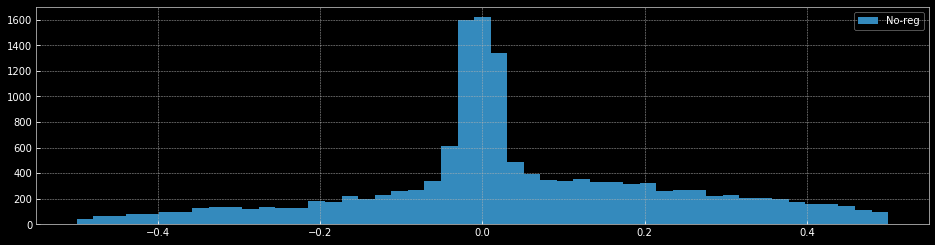

In [126]:
# Show weight distribution
plt.hist((
    weights.reshape(-1),
    #weights_L1.reshape(-1), # toggle 2
    #weights_L2.reshape(-1), # toggle 3
    #weights_max.reshape(-1), # toggle 4
), 49, range=(-.5, .5), label=(
    'No-reg',
    #'L1',
    #'L2',
    #'Max',
))
plt.legend();